## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()
import sys
import graphviz
sys.executable
#import graphviz


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


'c:\\users\\rapp\\appdata\\local\\programs\\python\\python36-32\\python.exe'

In [5]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

#### Do a test to make sure some pythonic lines of code work the way I think I do to bring data into a list format for the DecisionTree model

In [6]:
testtrain1 = []
testtrain2 = []
test_vars = ['LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_WindSpeed_mps']


#Method 1 [more pythonic]
loop_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
for v in test_vars:
    loop_idx = loop_idx & np.isfinite(asos_snotel_UA_df['2009':'2017'][v])

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
testlist1 = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
testtrain1 = testlist1.tolist()


#Method 2 [less pythonic]
# Explicitly list each feature

compare_idx = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Temperature_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_Dewpoint_degC']) & \
           np.isfinite(asos_snotel_UA_df['2009':'2017']['LXV_WindSpeed_mps'])

for index, rows in asos_snotel_UA_df['2009':'2017'][compare_idx].iterrows(): 
    # Create list for the current row 
    testlist2 =[rows['LXV_Temperature_degC'], rows['LXV_WindSpeed_mps'], rows['LXV_Dewpoint_degC']] 
    # append the list to the final list 
    testtrain2.append(testlist2)
    
print(len(loop_idx), len(compare_idx))
print(loop_idx.equals(compare_idx))
print(testtrain2 == testtrain1)


6574 6574
True
True


### Now identify variables which have good data capture

**SURFACE FEATURES**

In [113]:
max_snf = 50
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']

good_vars_sfc = []
bad_vars_sfc = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2006':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'])
    total_avail =len(asos_snotel_UA_df['2006':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars_sfc.append(var)
    else:
        bad_vars_sfc.append(var)

       
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_sfc)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_sfc)

Variables with >= 67% data match to snowfall: 
[]
Variables with < 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp']


In [ ]:
**UPPER AIR**

In [116]:
max_snf = 50
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars_UASFC = []
bad_vars_UASFC = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2006':'2017'][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss_UASFC = asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail_UASFC =len(asos_snotel_UA_df['2006':'2017'][idx]) 
    
    if total_avail_UASFC/total_poss_UASFC >= 0.67: 
        good_vars_UASFC.append(var)
    else:
        bad_vars_UASFC.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars_UASFC)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars_UASFC)
    

Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

# Filter dataset to only include meteorological data with matching snowfall event

In [1]:
Xtrain = []
Xtrain_feat =[]
Ytrain = []
Ytrain_actsnf = []
idx_train = []

idx_train = np.isfinite(asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']<max_snf])
for v in good_vars_sfc:
    idx_train = idx_train & np.isfinite(asos_snotel_UA_df['2009':'2017'][v])    
    
Ytrain = round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2009':'2017'][idx_train],0)
Ytrain_actsnf = Ytrain.tolist()


gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
Xtrain = asos_snotel_UA_df['2009':'2017'][good_vars_sfc][idx_train].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
Xtrain_feat = Xtrain.tolist()
    
print(Xtrain_feat[0:5], Ytrain_actsnf[0:5])



NameError: name 'np' is not defined

### Run sklearn model with surface features only

[4.60048237 5.17075618 4.80013205 4.81109825 4.58224351 3.15362949
 5.05439593 4.51358057 3.68346401 4.34219943 4.00863643 4.10607567
 3.25773409 4.01307923 4.4106493  4.17447384 5.55565791 3.56315797
 3.87585023 6.20772823 4.40310882 5.39562852 5.27822498 3.59759497
 4.75436306 4.3083747  3.52456061 4.04498291 4.18201282 4.28888147
 4.81259158 3.16444433 3.92234346 4.77502045 4.62041404 4.62544587
 4.83845605 4.1046356  4.28006005 3.86183434 3.45937504 5.8495066
 4.03411515 4.63638465 3.98532883 4.27253929 3.56162353 5.90893811
 5.3280416  4.14515534 5.31709694 3.17121262 3.92290861 5.08067225
 3.67381898 4.2759776  4.53736709 4.04513487 4.31456602 4.01274246
 4.91710873 4.00345861 3.45926316 2.05457015 4.21618817 3.00718005
 5.28250332 3.64441842 4.33453953 4.57748123 3.9296478  5.06814973
 4.44200822 4.96684467]


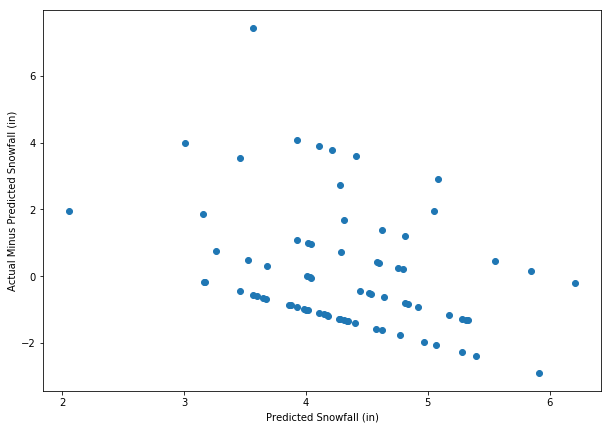

Score:-0.14701056369238152


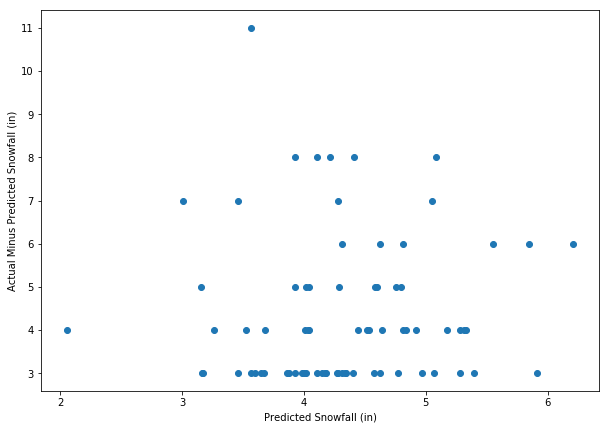

In [15]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

lm = linear_model.LinearRegression()
model = lm.fit(Xtrain_feat, Ytrain_actsnf)
Y_predsnf = lm.predict(Xtest_feat)

print(Y_predsnf)
fig1 = plt.figure(figsize=(10,7))

plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)
plt.xlabel('Predicted Snowfall (in)')
plt.ylabel('Actual Minus Predicted Snowfall (in)')
plt.show()

fig1 = plt.figure(figsize=(10,7))
plt.scatter(Y_predsnf, Ytest_actsnf)
plt.xlabel('Predicted Snowfall (in)')
plt.ylabel('Actual Minus Predicted Snowfall (in)')

print('Score:' +  str(model.score(Xtest_feat, Ytest_actsnf)))

# Now try Cross Validation using Timeseries split

In [19]:

X = []
X_feat =[]
Y = []
Y_actsnf = []
idx_test = []

idx = np.isfinite(asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2006':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']<max_snf])
for v in good_vars_sfc:
    idx = idx  & np.isfinite(asos_snotel_UA_df['2006':'2017'][v])    
    
print(len(idx))
Y= round(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2006':'2017'][idx],0)
Y_actsnf  = Y.tolist()

gv = pd.DataFrame()
#gv_asos_snotel_UA_df = asos_snotel_UA_df.copy
#gv_asos_snotel_UA_df = asos_snotel_UA_df['2009':'2017'][['LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'LXV_Dewpoint_degC']][loop_idx]
X = asos_snotel_UA_df['2006':'2017'][good_vars_sfc][idx].apply(lambda x: x.tolist(), axis=1)
#testtrain2 = testlist.apply(lambda x: testtrain2.append(x))
X_feat = X.tolist()
print(X_feat[0:5], Y_actsnf[0:5])


8766
[[-3.2, -7.0, -8.0, 340.0, 5.1, -4.4, -7.2, 993.4, 2.6, 70.0, -5.2], [-6.2, -9.0, -12.0, 290.0, 10.8, -6.7, -8.9, 1005.8, 4.1, 310.0, -4.2], [-8.2, -9.0, -12.0, 290.0, 7.7, -7.0, -9.0, 1004.3, 1.5, 180.0, -5.4], [-8.0, -9.0, -12.0, 310.0, 7.7, -7.2, -11.1, 1022.6, 1.5, 10.0, -2.4], [-4.3, -8.0, -12.0, 260.0, 9.8, -2.2, -12.2, 1003.9, 3.1, 310.0, -9.0]] [5.0, 4.0, 5.0, 4.0, 5.0]


TimeSeriesSplit(max_train_size=None, n_splits=5)
225
225
<generator object TimeSeriesSplit.split at 0x0FC46B70>
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] TEST: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76]
37
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76] TEST: [ 77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113]
37
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54 

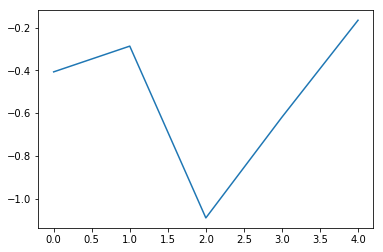

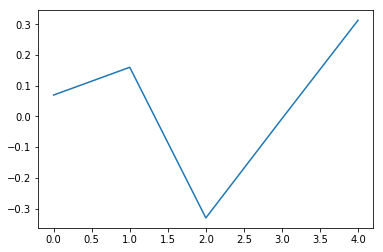

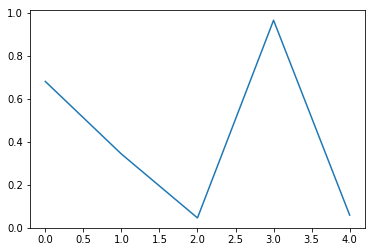

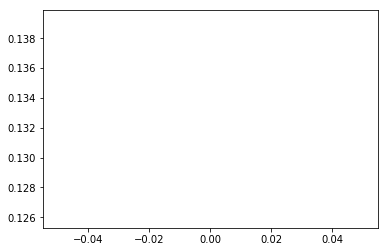

In [90]:
from sklearn.model_selection import TimeSeriesSplit # import KFold

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  
print(len(X_feat))
print(len(Y_actsnf))

print(tscv.split(X_feat))

slopes = []
intercepts =[]
r_values = []
p_values =[]
std_errs =[]

R2_scores =[]
X_train = np.array([])
 
for train_index, test_index in tscv.split(X_feat):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train =  np.array(X_feat)[train_index]
 X_test =  np.array(X_feat)[test_index]
 Y_train =  np.array(Y_actsnf)[train_index]
 Y_test =   np.array(Y_actsnf)[test_index]
 model = lm.fit(X_train, Y_train)
 #Y_predsnf = lm.predict(X_test)
 Ytest_predictions = cross_val_predict(model, X_test, Y_test, cv = 37)
 print(len(Y_test))
 R2_scores.append(metrics.r2_score(Y_test, Ytest_predictions))
 slope, intercept, r_value, p_value, std_err = linregress(Y_test, Ytest_predictions)    
 slopes.append(slope)
 intercepts.append(intercept)
 r_values.append(r_value)
 p_values.append(p_value)
 std_errs.append(std_err)
    

print("Mean R2=" + str(np.mean(R2_scores)))
print("Mean p value =" +str(np.mean(p_values)))
print("MIn p value ="+str(np.min(p_values)))
    
plt.plot(R2_scores)
plt.show()
plt.plot(r_values)
plt.show()
plt.plot(p_values)
plt.show()
plt.plot(std_err)





In [108]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

#scores = cross_val_score(model, X_feat, Y_actsnf, cv=TimeSeriesSplit(n_splits=5).split(X_feat))
scores = cross_val_score(model, X_feat, Y_actsnf, cv=tscv.split(X_feat))
print(scores)
print(np.mean(scores))




[-0.24057217 -0.47194574  0.0121163  -0.25136496  0.02408355]
-0.18553660557151058


DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
74


Text(0,0.5,'Actual Minus Predicted Snowfall (in)')

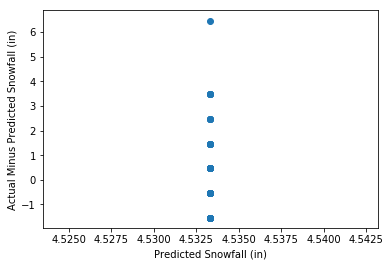

In [75]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=1)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


from sklearn.metrics import accuracy_score
#print(accuracy_score(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 
print(len(Y_predsnf))

plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)
plt.xlabel('Predicted Snowfall (in)')
plt.ylabel('Actual Minus Predicted Snowfall (in)')

Graphically view

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']


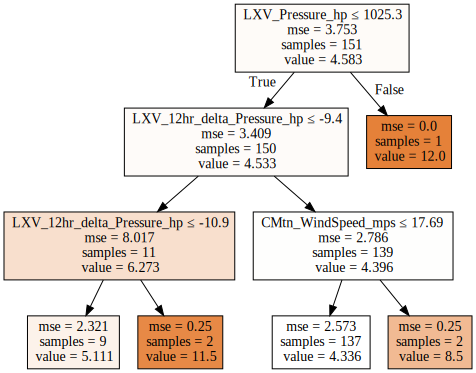

In [84]:

import graphviz 

fn = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
dot_data = tree.export_graphviz(clf, out_file=None, \
                                feature_names=['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp'], \
                                label = 'all', filled = True,special_characters = True, class_names = True, max_depth = 3) 

print(good_vars_sfc)
graph = graphviz.Source(dot_data) 
#graph.render() 
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                      feature_names=iris.feature_names,  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True)

#dot_data = tree.export_graphviz(clf)
tree.export_graphviz(clf)
graph = graphviz.Source(dot_data)  
graph 

Try max depth 10

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
8.000654821488155


Text(0,0.5,'Actual Minus Predicted Snowfall (in)')

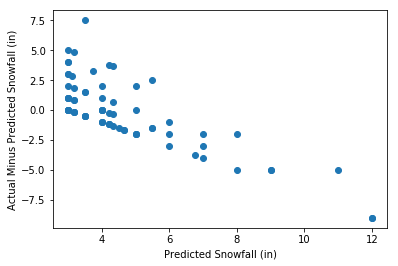

In [69]:
clf =[]
Y_predsnf = []

from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=10)
clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

print(clf)

# Predict test set labels
Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


from sklearn.metrics import mean_squared_error
print(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 


plt.scatter(Y_predsnf, Ytest_actsnf-Y_predsnf)
plt.xlabel('Predicted Snowfall (in)')
plt.ylabel('Actual Minus Predicted Snowfall (in)')

Try multpile max depths

Text(0,0.5,'Accuracy Score')

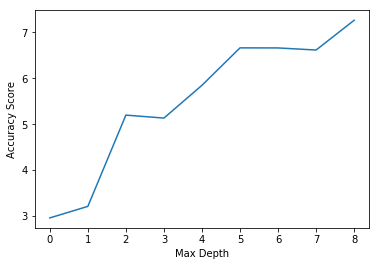

In [73]:
from sklearn import tree
from sklearn.metrics import accuracy_score
accuracy = []

for i in range(1,10):
  clf = []
  clf = tree.DecisionTreeRegressor(max_depth=i)
  clf = clf.fit(Xtrain_feat, Ytrain_actsnf)

#print(clf)

# Predict test set labels
  Y_predsnf = clf.predict(Xtest_feat)
# Evaluate test-set accuracy


  accuracy.append(mean_squared_error(Ytest_actsnf, Y_predsnf))
#plt.plot(Ytestlist-y_pred) 

plt.plot(accuracy)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
#plt.scatter(y_pred, Ytestlist-y_pred)

151


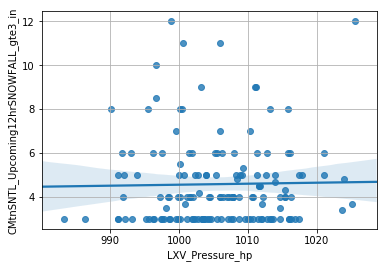

In [78]:
#plt.plot(Ytest_actsnf)
#asos_snotel_UA_df['2009':'2017'][good_vars_sfc][idx_train]
print(len(asos_snotel_UA_df['2009':'2017']['LXV_Pressure_hp'][idx_train]))
sns.regplot(asos_snotel_UA_df['2009':'2017']['LXV_Pressure_hp'][idx_train], asos_snotel_UA_df['2009':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][idx_train])
plt.grid(True)

74


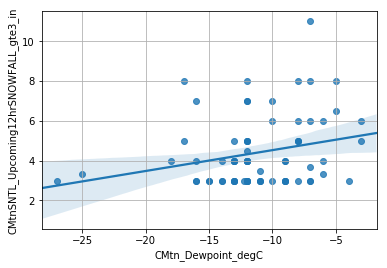

In [72]:
print(len(asos_snotel_UA_df['2006':'2008']['CMtn_Dewpoint_degC'][idx_test]))
sns.regplot(asos_snotel_UA_df['2006':'2008']['CMtn_Dewpoint_degC'][idx_test], asos_snotel_UA_df['2006':'2008']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][idx_test])
plt.grid(True)